In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import copy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import ARMAConv

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/snu/an

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
print("X Shape:", X.shape)
print("y Shape:", y.shape)

Patients Shape: (98, 180)
Controls Shape: (48, 180)
X Shape: (146, 180)
y Shape: (146,)


In [4]:
def sim(h1, h2, tau=0.2):
    z1 = nnF.normalize(h1, dim=-1, p=2)
    z2 = nnF.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    # diagonal numerator; denominator excludes intra diag
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag() + 1e-12))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / (cross_sim.sum(dim=-1) + 1e-12))

In [5]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class ARMAEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ="SELU", num_stacks=1, num_layers=1):
        super(ARMAEncoder, self).__init__()
        self.device = device
        # Activation mapping for internal ARMA nonlinearity
        activations = {
            "SELU": nnF.selu,
            "SiLU": nnF.silu,
            "GELU": nnF.gelu,
            "ELU": nnF.elu,
            "RELU": nnF.relu
        }
        self.act = activations.get(activ, nnF.elu)

        self.arma = ARMAConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,
            num_layers=num_layers,
            act=self.act,
            shared_weights=True,
            dropout=0.25
        )
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.arma(x, edge_index)
        x = self.dropout(x)
        x = self.batchnorm(x)
        logits = self.mlp(x)
        return logits

In [7]:
class EMA():
    def __init__(self, beta):
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [8]:
class ARMA(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.99, cut=True):
        super(ARMA, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        # beta for mixing in contrastive combination
        self.beta = 0.6

        self.online_encoder = ARMAEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)
        # freeze target encoder params
        for p in self.target_encoder.parameters():
            p.requires_grad = False

        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)

        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        # online projections
        x1 = self.online_encoder(data1)      # shape: N x hidden
        logits1 = self.online_predictor(x1)  # predictor outputs (raw)
        S1 = nnF.softmax(logits1, dim=1)

        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnF.softmax(logits2, dim=1)

        # target projections (no grads)
        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()

        # contrastive style losses
        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)

        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)

        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnF.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m + 1e-12)

        k = torch.tensor(self.num_clusters, device=self.device, dtype=torch.float32)
        n = S.shape[0]

        modularity_term = (-1.0 / (2.0 * m + 1e-12)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1.0

        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnF.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)

        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / (den + 1e-12))

        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / (torch.norm(St_S) + 1e-12) - I_S / (torch.norm(I_S) + 1e-12))

        return mincut_loss + ortho_loss

In [9]:
def create_adj(features, cut, alpha=1.0):
    F_norm = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-12)
    W = np.dot(F_norm, F_norm.T)

    if cut == 0:
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        if W.max() > 0:
            W = (W / W.max()).astype(np.float32)
    else:
        W = (W * (W >= alpha)).astype(np.float32)
    return W

def edge_index_from_dense(W):
    rows, cols = np.nonzero(W > 0)
    edge_index = np.vstack([rows, cols]).astype(np.int64)
    edge_weight = W[rows, cols].astype(np.float32)
    return edge_index, edge_weight

def build_adj_list(edge_index_np, num_nodes):
    adj = [[] for _ in range(num_nodes)]
    src = edge_index_np[0]
    dst = edge_index_np[1]
    for s, d in zip(src, dst):
        adj[s].append(d)
    adj = [np.array(neis, dtype=np.int64) if len(neis) > 0 else np.array([], dtype=np.int64) for neis in adj]
    return adj

def aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=None):
    rng = np.random.default_rng(seed)
    E = edge_index_np.shape[1]
    keep_mask = rng.random(E) >= drop_percent
    new_edge_index = edge_index_np[:, keep_mask]
    return new_edge_index

def aug_subgraph_edge_index(features_np, edge_index_np, adj_list, drop_percent=0.2, seed=None):
    rng = np.random.default_rng(seed)
    num_nodes = features_np.shape[0]
    s_node_num = int(num_nodes * (1 - drop_percent))
    s_node_num = max(1, s_node_num)

    center_node = int(rng.integers(0, num_nodes))
    sub_nodes = [center_node]
    front_idx = 0

    while len(sub_nodes) < s_node_num and front_idx < len(sub_nodes):
        cur = sub_nodes[front_idx]
        neighbors = adj_list[cur]
        if neighbors.size > 0:
            nbrs_shuffled = neighbors.copy()
            rng.shuffle(nbrs_shuffled)
            for nb in nbrs_shuffled:
                if nb not in sub_nodes:
                    sub_nodes.append(int(nb))
                    if len(sub_nodes) >= s_node_num:
                        break
        front_idx += 1
        if front_idx >= len(sub_nodes) and len(sub_nodes) < s_node_num:
            remaining = [n for n in range(num_nodes) if n not in sub_nodes]
            if not remaining:
                break
            add = int(rng.choice(remaining))
            sub_nodes.append(add)

    sub_nodes = sorted(set(sub_nodes))
    node_map = {old: new for new, old in enumerate(sub_nodes)}

    src = edge_index_np[0]
    dst = edge_index_np[1]
    mask_src_in = np.isin(src, sub_nodes)
    mask_dst_in = np.isin(dst, sub_nodes)
    mask = mask_src_in & mask_dst_in
    sel_src = src[mask]
    sel_dst = dst[mask]
    remapped_src = np.array([node_map[int(s)] for s in sel_src], dtype=np.int64)
    remapped_dst = np.array([node_map[int(d)] for d in sel_dst], dtype=np.int64)
    new_edge_index = np.vstack([remapped_src, remapped_dst])
    sub_features = features_np[sub_nodes, :].astype(np.float32)
    return sub_features, new_edge_index

def load_data_from_edge_index(node_feats_np, edge_index_np, device):
    node_feats = torch.from_numpy(node_feats_np).float()
    edge_index = torch.from_numpy(edge_index_np.astype(np.int64)).long()
    return node_feats, edge_index

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_dim = 256
K = 2
num_epochs = 2000
alpha = 0.5
features = X.astype(np.float32)
num_nodes = features.shape[0]
feat_dim = features.shape[1]
W0 = create_adj(features, cut=0, alpha=alpha)
edge_index_np, edge_weight_np = edge_index_from_dense(W0)
adj_list = build_adj_list(edge_index_np, num_nodes)
node_feats_all, edge_index_all = load_data_from_edge_index(features, edge_index_np, device)
data_full = Data(x=node_feats_all.to(device), edge_index=edge_index_all.to(device))
print(f"Data: {data_full}")

A1 = torch.from_numpy(W0).float().to(device)

Data: Data(x=[146, 180], edge_index=[2, 21256])



=== Fold 1 ===
Epoch 0 | Total=0.4361 | Cont=5.0294 | CE=0.6178 | Unsup=-0.2320
Epoch 500 | Total=-0.3611 | Cont=4.8329 | CE=0.0415 | Unsup=-0.4509
Epoch 1000 | Total=-0.4138 | Cont=4.7829 | CE=0.0033 | Unsup=-0.4648
Epoch 1500 | Total=-0.3947 | Cont=4.7632 | CE=0.0003 | Unsup=-0.4426
Fold 1 → Acc=0.6212 F1=0.6835 AUC=0.6640

=== Fold 2 ===
Epoch 0 | Total=0.5463 | Cont=5.0469 | CE=0.7269 | Unsup=-0.2311
Epoch 500 | Total=-0.3332 | Cont=4.7072 | CE=0.0863 | Unsup=-0.4665
Epoch 1000 | Total=-0.4036 | Cont=4.5973 | CE=0.0170 | Unsup=-0.4666
Epoch 1500 | Total=-0.3988 | Cont=4.7482 | CE=0.0161 | Unsup=-0.4623
Fold 2 → Acc=0.6288 F1=0.7263 AUC=0.6595

=== Fold 3 ===
Epoch 0 | Total=0.5557 | Cont=5.0029 | CE=0.7371 | Unsup=-0.2315
Epoch 500 | Total=-0.3980 | Cont=4.8078 | CE=0.0197 | Unsup=-0.4658
Epoch 1000 | Total=-0.4329 | Cont=4.6760 | CE=0.0018 | Unsup=-0.4815
Epoch 1500 | Total=-0.4072 | Cont=4.7994 | CE=0.0056 | Unsup=-0.4608
Fold 3 → Acc=0.7500 F1=0.8156 AUC=0.8247

=== Fold 4 ===


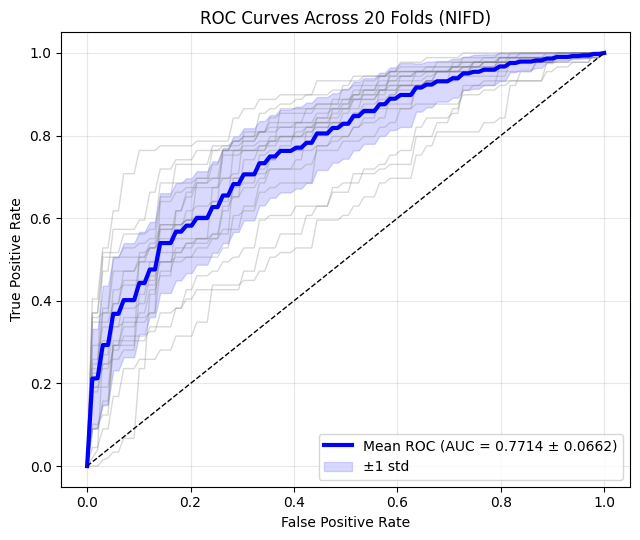

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, log_loss, roc_auc_score, roc_curve, auc
)

# -------------------------
# Metric containers
# -------------------------
accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []

# For ROC
mean_fpr = np.linspace(0, 1, 100)
tprs = []
auc_per_fold = []

# -------------------------
# Cross-validation
# -------------------------
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=SEED)

for fold, (train_idx_full, test_idx) in enumerate(sss.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    # ---- Balanced tiny supervised set (CN vs AD) ----
    cn_idx = np.where(y == 0)[0]
    ad_idx = np.where(y == 1)[0]

    sss_class = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=fold)
    cn_train_idx, _ = next(sss_class.split(X[cn_idx], y[cn_idx]))
    ad_train_idx, _ = next(sss_class.split(X[ad_idx], y[ad_idx]))

    balanced_train_idx = np.concatenate([
        cn_idx[cn_train_idx],
        ad_idx[ad_train_idx]
    ])
    np.random.shuffle(balanced_train_idx)

    train_idx_t = torch.from_numpy(balanced_train_idx).long().to(device)
    test_idx_t = torch.from_numpy(test_idx).long().to(device)
    y_tensor = torch.from_numpy(y).long().to(device)

    # ---- Model ----
    model = ARMA(
        feat_dim, hidden_dim, K,
        device, activ="SELU",
        cut=True, moving_average_decay=0.99
    ).to(device)

    classifier = nn.Linear(hidden_dim, K).to(device)

    optimizer = optim.Adam(
        list(model.parameters()) + list(classifier.parameters()),
        lr=1e-4, weight_decay=1e-4
    )
    ce_loss = nn.CrossEntropyLoss()

    # -------------------------
    # Training
    # -------------------------
    for ep in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        edge_index_aug1 = aug_random_edge_edge_index(edge_index_np, 0.2, seed=ep)
        edge_index_aug2 = aug_random_edge_edge_index(edge_index_np, 0.2, seed=ep + 999)

        rng = np.random.default_rng(ep)
        mask = rng.random(features.shape) >= 0.2
        features_aug1 = features * mask.astype(np.float32)

        aug_feat2 = features.copy()
        drop_feat_num = int(features.size * 0.2)
        flat_idx = rng.choice(features.size, drop_feat_num, replace=False)
        rows = flat_idx // features.shape[1]
        cols = flat_idx % features.shape[1]
        aug_feat2[rows, cols] = 0.0
        features_aug2 = aug_feat2.astype(np.float32)

        node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, edge_index_aug1, device)
        node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, edge_index_aug2, device)

        data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))
        data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

        S1, S2, logits1, logits2, l1, l2 = model(data1, data2)
        cont_loss = ((l1 + l2) / 2.0).mean()

        embeddings = model.online_encoder(data_full)
        logits_sup = classifier(embeddings[train_idx_t])
        sup_loss = ce_loss(logits_sup, y_tensor[train_idx_t])

        unsup_loss = model.loss(A1, logits1)

        loss = 0.01 * cont_loss + sup_loss + unsup_loss
        loss.backward()
        optimizer.step()
        model.update_ma()

        if ep % 500 == 0:
            print(
                f"Epoch {ep} | Total={loss.item():.4f} | "
                f"Cont={cont_loss.item():.4f} | "
                f"CE={sup_loss.item():.4f} | "
                f"Unsup={unsup_loss.item():.4f}"
            )

    # -------------------------
    # Evaluation
    # -------------------------
    model.eval()
    classifier.eval()

    with torch.no_grad():
        emb = model.online_encoder(data_full)
        logits = classifier(emb)
        probs = nnF.softmax(logits, dim=1).cpu().numpy()
        y_pred = np.argmax(probs, axis=1)

    y_test = y[test_idx]
    y_pred_test = y_pred[test_idx]
    y_proba_test = probs[test_idx, 1]

    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)

    try:
        loss_val = log_loss(y_test, y_proba_test)
    except Exception:
        loss_val = np.nan

    try:
        auc_score = roc_auc_score(y_test, y_proba_test)
    except Exception:
        auc_score = np.nan

    # ---- ROC curve for this fold ----
    try:
        fpr, tpr, _ = roc_curve(y_test, y_proba_test)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_per_fold.append(auc_score)
    except Exception:
        pass

    print(f"Fold {fold+1} → Acc={acc:.4f} F1={f1:.4f} AUC={auc_score:.4f}")

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_score)

# -------------------------
# Aggregate metrics
# -------------------------
print("\n=== Average Results ===")
print(f"Accuracy: {np.nanmean(accuracies):.4f} ± {np.nanstd(accuracies):.4f}")
print(f"Precision: {np.nanmean(precisions):.4f} ± {np.nanstd(precisions):.4f}")
print(f"Recall: {np.nanmean(recalls):.4f} ± {np.nanstd(recalls):.4f}")
print(f"F1: {np.nanmean(f1_scores):.4f} ± {np.nanstd(f1_scores):.4f}")
print(f"LogLoss: {np.nanmean(losses):.4f} ± {np.nanstd(losses):.4f}")
print(f"AUC: {np.nanmean(all_auc):.4f} ± {np.nanstd(all_auc):.4f}")

# -------------------------
# Plot ROC curves (all folds + mean)
# -------------------------
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.nanstd(auc_per_fold)

plt.figure(figsize=(6.5, 5.5))

# Individual folds
for i in range(len(tprs)):
    plt.plot(mean_fpr, tprs[i], color="gray", lw=1, alpha=0.3)

# Mean ROC (highlighted)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=3,
    label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})"
)

# Std band
plt.fill_between(
    mean_fpr,
    np.maximum(mean_tpr - std_tpr, 0),
    np.minimum(mean_tpr + std_tpr, 1),
    color="blue",
    alpha=0.15,
    label="±1 std"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="black", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across 20 Folds (NIFD)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=SEED)
for fold, (train_idx_full, test_idx) in enumerate(sss.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    # Build a tiny balanced "train" set within the fold for supervised head
    cn_idx = np.where(y == 0)[0]
    mci_idx = np.where(y == 1)[0]
    sss_class = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=fold)
    cn_train_idx, _ = next(sss_class.split(X[cn_idx], y[cn_idx]))
    mci_train_idx, _ = next(sss_class.split(X[mci_idx], y[mci_idx]))
    cn_train = cn_idx[cn_train_idx]
    mci_train = mci_idx[mci_train_idx]
    balanced_train_idx = np.concatenate([cn_train, mci_train])
    np.random.shuffle(balanced_train_idx)

    train_idx_t = torch.from_numpy(balanced_train_idx).long().to(device)
    test_idx_t = torch.from_numpy(test_idx).long().to(device)
    y_tensor = torch.from_numpy(y).long().to(device)

    model = ARMA(feat_dim, hidden_dim, K, device, activ="SELU", cut=False, moving_average_decay=0.99).to(device)
    classifier = nn.Linear(hidden_dim, K).to(device)
    optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=1e-4, weight_decay=1e-4)
    ce_loss = nn.CrossEntropyLoss()

    for ep in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Aug 1: random edge drop
        edge_index_aug1 = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=ep)
        # Aug 2: independent random edge drop
        edge_index_aug2 = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=ep+999)

        rng = np.random.default_rng(ep)
        mask = rng.random(features.shape) >= 0.2
        features_aug1 = (features * mask.astype(np.float32))

        aug_feat2 = features.copy()
        drop_feat_num = int(features.shape[0] * features.shape[1] * 0.2)
        flat_idx = rng.choice(features.shape[0] * features.shape[1], size=drop_feat_num, replace=False)
        rows = (flat_idx // features.shape[1])
        cols = (flat_idx % features.shape[1])
        aug_feat2[rows, cols] = 0.0
        features_aug2 = aug_feat2.astype(np.float32)

        node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, edge_index_aug1, device)
        data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))
        node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, edge_index_aug2, device)
        data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

        S1, S2, logits1, logits2, l1, l2 = model(data1, data2)
        cont_loss = ((l1 + l2) / 2.0).mean()

        embeddings = model.online_encoder(data_full)
        logits_sup = classifier(embeddings[train_idx_t])
        sup_loss = ce_loss(logits_sup, y_tensor[train_idx_t])

        unsup_loss = model.loss(A1, logits1)

        loss = 0.01 * cont_loss + sup_loss + unsup_loss

        loss.backward()
        optimizer.step()
        model.update_ma()

        if ep % 500 == 0 or ep == 1:
            print(f"Epoch {ep} | Total: {loss.item():.6f} | Cont: {cont_loss.item():.6f} | CE: {sup_loss.item():.6f} | Unsup: {unsup_loss.item():.6f}")

    # --- Eval for this fold ---
    model.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings_final = model.online_encoder(data_full)
        logits_final = classifier(embeddings_final)
        probs = nnF.softmax(logits_final, dim=1).cpu().numpy()
        y_pred = np.argmax(probs, axis=1)

    y_test = y[test_idx]
    y_pred_test = y_pred[test_idx]
    # ensure probability vector for class 1 exists
    y_proba_test = probs[test_idx, 1] if probs.shape[1] > 1 else probs[test_idx, 0]

    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)

    # log_loss expects shape (n_samples,) probabilities for binary, or (n_samples, n_classes)
    try:
        loss_val = log_loss(y_test, y_proba_test)
    except Exception:
        loss_val = np.nan

    try:
        auc_score = roc_auc_score(y_test, y_proba_test)
    except Exception:
        auc_score = np.nan

    print(f"Fold {fold+1} → Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f} AUC={auc_score:.4f}")

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_score)

print("\n=== Average Results ===")
print(f"Accuracy: {np.nanmean(accuracies):.4f} ± {np.nanstd(accuracies):.4f}")
print(f"Precision: {np.nanmean(precisions):.4f} ± {np.nanstd(precisions):.4f}")
print(f"Recall: {np.nanmean(recalls):.4f} ± {np.nanstd(recalls):.4f}")
print(f"F1: {np.nanmean(f1_scores):.4f} ± {np.nanstd(f1_scores):.4f}")
print(f"LogLoss: {np.nanmean(losses):.4f} ± {np.nanstd(losses):.4f}")
print(f"AUC: {np.nanmean(all_auc):.4f} ± {np.nanstd(all_auc):.4f}")


=== Fold 1 ===
Epoch 0 | Total: 0.554453 | Cont: 5.029397 | CE: 0.617820 | Unsup: -0.113661
Epoch 1 | Total: 0.714424 | Cont: 5.039456 | CE: 0.780275 | Unsup: -0.116246
Epoch 500 | Total: -0.037885 | Cont: 4.835181 | CE: 0.038957 | Unsup: -0.125194
Epoch 1000 | Total: -0.074295 | Cont: 4.753562 | CE: 0.003468 | Unsup: -0.125298
Epoch 1500 | Total: -0.078342 | Cont: 4.659699 | CE: 0.000154 | Unsup: -0.125092
Fold 1 → Acc=0.6212 Prec=0.7671 Rec=0.6292 F1=0.6914 AUC=0.6547

=== Fold 2 ===
Epoch 0 | Total: 0.669788 | Cont: 5.046941 | CE: 0.726913 | Unsup: -0.107594
Epoch 1 | Total: 0.628163 | Cont: 5.052037 | CE: 0.685762 | Unsup: -0.108120
Epoch 500 | Total: 0.001036 | Cont: 4.851452 | CE: 0.077692 | Unsup: -0.125171
Epoch 1000 | Total: -0.058260 | Cont: 4.784524 | CE: 0.018902 | Unsup: -0.125007
Epoch 1500 | Total: -0.065794 | Cont: 4.889958 | CE: 0.010648 | Unsup: -0.125341
Fold 2 → Acc=0.6136 Prec=0.7111 Rec=0.7191 F1=0.7151 AUC=0.6671

=== Fold 3 ===
Epoch 0 | Total: 0.676589 | Cont:

Saved: /content/drive/MyDrive/TejaswiAbburi_va797/Dataset/nifti_images/CN_mid_slice.png
Saved: /content/drive/MyDrive/TejaswiAbburi_va797/Dataset/nifti_images/MCI_mid_slice.png
Saved: /content/drive/MyDrive/TejaswiAbburi_va797/Dataset/nifti_images/AD_mid_slice.png


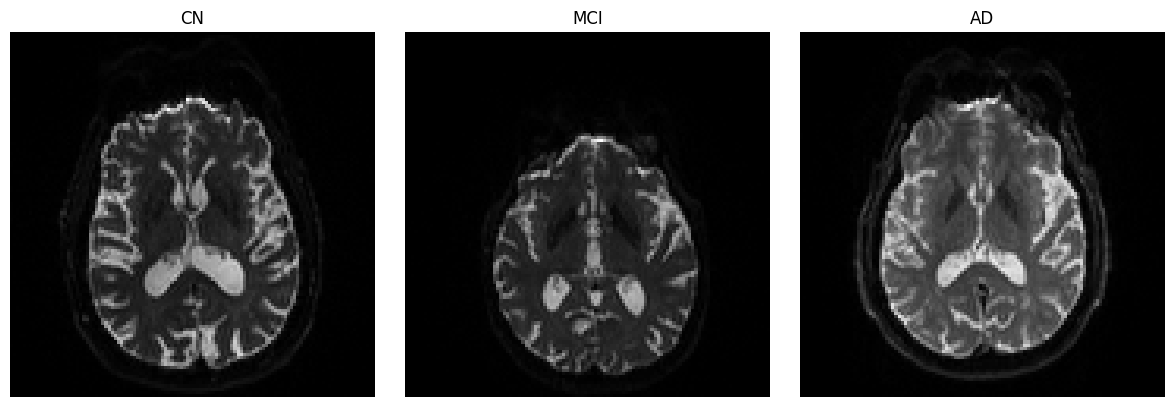

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

paths = [
    "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Ordered_4d_all_CN/all_55_diff_4d_img_ordered_CN/4d_img_DTI_016_S_6381_M_73_CN.nii.gz",
    "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Ordered_4d_all_MCI/all_55_diff_4d_img_ordered_MCI/4d_img_DTI_016_S_6926_F_81_MCI.nii.gz",
    "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_AD_dataset/Ordered_4d_all_AD/all_55_diff_4d_img_ordered_AD/4d_img_DTI_003_S_6264_M_55_AD.nii.gz"
]

labels = ["CN", "MCI", "AD"]

# Output directory to save images
output_dir = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/nifti_images"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 4))

for i, (path, label) in enumerate(zip(paths, labels)):

    if not os.path.exists(path):
        print(f"File not found, skipping: {path}")
        continue

    # Load NIfTI file
    img = nib.load(path)
    data = img.get_fdata()

    # If 4D DTI, take the first volume
    if data.ndim == 4:
        data = data[..., 0]

    # Take middle axial slice
    mid_slice = data.shape[2] // 2
    slice_img = data[:, :, mid_slice].T

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.imshow(slice_img, cmap="gray", origin="lower")
    plt.title(label)
    plt.axis("off")

    # Save image
    save_path = os.path.join(output_dir, f"{label}_mid_slice.png")
    plt.imsave(save_path, slice_img, cmap="gray")
    print(f"Saved: {save_path}")

plt.tight_layout()
plt.show()


In [ ]:
ls /home/snu/Downloads/4d_img_DTI_016_S_6839_F_70_AD_nii.gz


ls: cannot access '/home/snu/Downloads/4d_img_DTI_016_S_6839_F_70_AD_nii.gz': No such file or directory


# Task
Define the `SEED` variable, then update the training loop to rename `cn_idx` to `control_idx` and `mci_idx` to `patient_idx`, and finally execute the training and evaluation to summarize the model's performance using the 'Control' and 'Patient' labels.

## Define SEED and Rename Indices

### Subtask:
Define the `SEED` variable and rename `cn_idx` to `control_idx` and `mci_idx` to `patient_idx` in the training loop to match 'Control' and 'Patient' terminology, improving code clarity and resolving the `NameError`.


**Reasoning**:
The first instruction is to define the `SEED` variable in a new code cell. This will resolve the `NameError` in cell `unLiGhaXn39r` and set a consistent random seed for reproducibility.

